In [3]:
import xarray as xr
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
def process_nc_file(sat_file, unc_file):
    # Load satellite data
    sat_data = xr.open_dataset(sat_file).sel(lat=slice(10, 72), lon=slice(-180., -50)).to_dataframe()
    
    # Load uncertainty data
    unc_data = xr.open_dataset(unc_file).sel(lat=slice(10, 72), lon=slice(-180., -50)).to_dataframe()
    
    # Merge and calculate percent uncertainty
    merged = pd.merge(sat_data, unc_data, left_index=True, right_index=True, how='inner')
    merged.reset_index(inplace=True)
    merged['percent'] = (merged['GWRPM25SIGMA'] / merged['GWRPM25']) * 100
    
    # Filter and return
    return merged[merged['percent'] >= 90][['lat', 'lon', 'GWRPM25','percent']]

# Process each year's files
greater_90 = process_nc_file(
    '/data/acker/WashU_V5_GL/V5GL04.HybridPM25.Global.201501-201512.nc',
    '/data/acker/WashU_GL_unc/V5GL04.HybridPM25E.Global.201501-201512.nc'
)


In [4]:
greater_90

,lat,lon,GWRPM25,percent
539254,66.544998,-179.074997,2.3,91.304344
614652,66.525002,-178.945007,2.3,91.304344
614653,66.535004,-178.945007,2.2,100.000000
614654,66.544998,-178.945007,2.4,95.833328
614655,66.555000,-178.945007,2.3,100.000000
...,...,...,...,...
75399995,67.955002,-50.005001,1.1,890.909119
75399996,67.964996,-50.005001,1.1,890.909119
75399997,67.974998,-50.005001,1.1,890.909119
75399998,67.985001,-50.005001,1.1,890.909119


In [12]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import dask
import glob
import os
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors

In [13]:
import geopandas as gpd
# Replace with the path to your US states shapefile
states_gdf = gpd.read_file('/data/acker/for_lizzy/cb_2023_us_state_20m.shp')

# Ensure the shapefile is in WGS 84 (latitude/longitude)
states_gdf = states_gdf.to_crs(epsg=4326)
# Removing rows where 'NAME' is 'Texas' or 'California'
states_gdf = states_gdf[~states_gdf['NAME'].isin(['Puerto Rico'])]
states_gdf.NAME.unique()

array(['Texas', 'California', 'Kentucky', 'Georgia', 'Wisconsin',
       'Oregon', 'Missouri', 'Virginia', 'Tennessee', 'Louisiana',
       'New York', 'Idaho', 'Florida', 'Illinois', 'Montana', 'Minnesota',
       'Maryland', 'Iowa', 'District of Columbia', 'Washington',
       'South Dakota', 'Ohio', 'Nebraska', 'Indiana', 'Massachusetts',
       'Nevada', 'North Dakota', 'Arkansas', 'Mississippi', 'Colorado',
       'North Carolina', 'Utah', 'Oklahoma', 'Wyoming', 'West Virginia',
       'South Carolina', 'Maine', 'Hawaii', 'Alabama', 'Kansas',
       'Rhode Island', 'Connecticut', 'Michigan', 'Alaska', 'Delaware',
       'New Mexico', 'Vermont', 'New Jersey', 'Pennsylvania',
       'New Hampshire', 'Arizona'], dtype=object)

In [14]:
lon2d, lat2d = np.meshgrid(filtered_20.lon, filtered_20.lat)

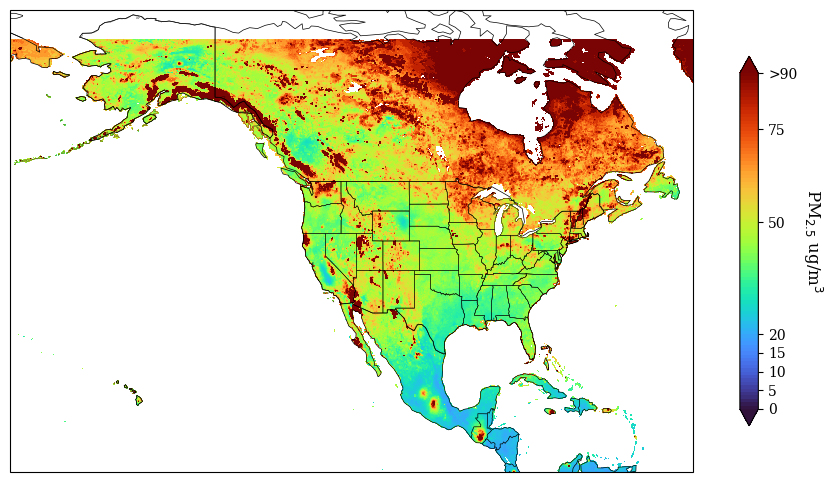

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors

# Load custom font
plt.rcParams["font.family"] = "serif"

# Assuming 'filtered_ds' is your xarray dataset
# lon2d, lat2d = np.meshgrid(filtered_ds.lon, filtered_ds.lat)  # Create 2D coordinates for plotting

# Load shapefile of state boundaries

# Set up the Cartopy map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for lat/lon data
ax.set_extent([-180, -50, 10, 72], crs=ccrs.PlateCarree())  # Adjust extent for the entire US

# Add map features
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="black")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor="black")
ax.add_feature(cfeature.STATES, linewidth=0.2, edgecolor="black")

# Plot the filled contours
colormap = 'turbo'
levels = np.linspace(0, 90, 100)
norm = colors.Normalize(vmin=0, vmax=90)
con = plt.contourf(lon2d, lat2d, filtered_20.percent.values, levels=levels, cmap=colormap,
                   norm=norm, transform=ccrs.PlateCarree(), extend='both')

# Overlay state boundaries
states_gdf.boundary.plot(ax=ax, color='black', linewidth=0.2, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(con, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label(r'PM$_{2.5}$ ug/m$^3$', fontsize=12, rotation=270, labelpad=20)

# Set tick labels for the colorbar, indicating <=4 and >=14
bounfiltered_ds = np.array([0,10,25,50,75, 90])
cbar.set_ticks(bounfiltered_ds)
cbar_labels = ['0'] + [f'{tick}' for tick in bounfiltered_ds[1:-1]] + ['>90']
cbar.set_ticklabels(cbar_labels)

# Remove the minor ticks
cbar.ax.yaxis.set_ticks([], minor=True)

# Title
#plt.title(r'Average 2020-2022 PM$_{2.5}$', fontsize=16)

# Save or show the plot
# plt.savefig('pm_avg_cartopy.png', dpi=600)
plt.show()


In [24]:
def process_nc_file(sat_file, unc_file):
    # Load satellite and uncertainty data
    sat_data = xr.open_dataset(sat_file).sel(lat=slice(10, 72), lon=slice(-180., -50))
    unc_data = xr.open_dataset(unc_file).sel(lat=slice(10, 72), lon=slice(-180., -50))
    
    # Calculate the 90th percentile of uncertainty
    percentile_90 = sat_data['GWRPM25'].quantile(0.90, dim=['lat', 'lon'])
    print(percentile_90.values)
    # Mask sat_data wherever unc_data exceeds the 90th percentile
    sat_data_filtered = sat_data.where(sat_data['GWRPM25'] >= percentile_90)
    
    # Return filtered satellite data
    return sat_data_filtered

# Process NetCDF files
filtered_20 = process_nc_file(
    '/data/acker/WashU_V5_NA/V5NA04.02.HybridPM25.xNorthAmerica.2015001-2015364.nc',
    '/data/acker/WashU_NA_unc/V5NA04.02.HybridPM25EFull.xNorthAmerica.2015001-2015364.nc'
)

9.0


In [25]:
filtered_20

<xarray.Dataset> Size: 255MB
Dimensions:   (lat: 5400, lon: 11800)
Coordinates:
  * lon       (lon) float64 94kB -170.0 -170.0 -170.0 ... -52.02 -52.02 -52.01
  * lat       (lat) float64 43kB 14.01 14.02 14.03 14.04 ... 67.97 67.98 68.0
    quantile  float64 8B 0.9
Data variables:
    GWRPM25   (lat, lon) float32 255MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    Title:            Hybrid PM_2_._5 [\mug/m^3]
    Contact:          Aaron van Donkelaar <aaron.vandonkelaar@wustl.edu>
    References:       van Donkelaar et al., Monthly Global Estimates of Fine ...
    Filename:         ./RegionalGWR-NA-BiWeekly-Geo20230823-GM20230905-V20240...
    Format:           NetCDF-4
    Delta_Lat:        0.01
    Delta_Lon:        0.01
    SpatialCoverage:  xNorthAmerica
    Start_Date:       2015001
    End_Date:         2015364

In [26]:
lon2d, lat2d = np.meshgrid(filtered_20.lon, filtered_20.lat)

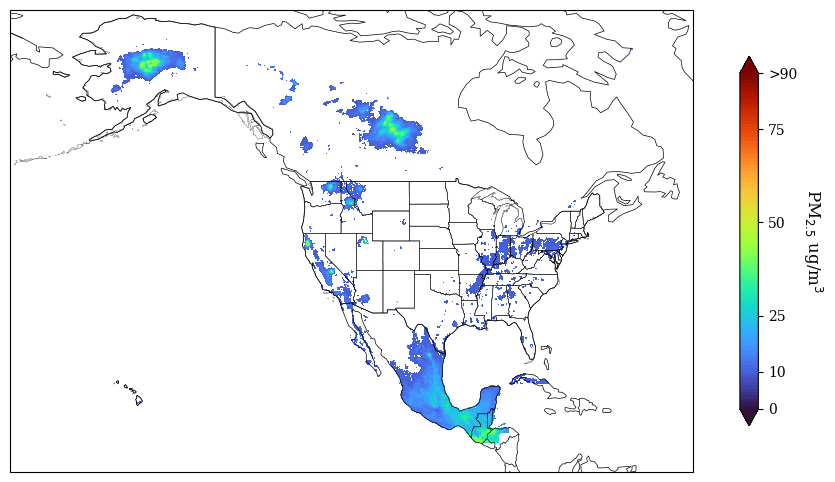

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colors

# Load custom font
plt.rcParams["font.family"] = "serif"

# Assuming 'filtered_ds' is your xarray dataset
# lon2d, lat2d = np.meshgrid(filtered_ds.lon, filtered_ds.lat)  # Create 2D coordinates for plotting

# Load shapefile of state boundaries

# Set up the Cartopy map
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for lat/lon data
ax.set_extent([-180, -50, 10, 72], crs=ccrs.PlateCarree())  # Adjust extent for the entire US

# Add map features
ax.add_feature(cfeature.BORDERS, linewidth=0.5, edgecolor="black")
ax.add_feature(cfeature.COASTLINE, linewidth=0.5, edgecolor="black")
ax.add_feature(cfeature.STATES, linewidth=0.2, edgecolor="black")

# Plot the filled contours
colormap = 'turbo'
levels = np.linspace(0, 90, 100)
norm = colors.Normalize(vmin=0, vmax=90)
con = plt.contourf(lon2d, lat2d, filtered_20.GWRPM25.values, levels=levels, cmap=colormap,
                   norm=norm, transform=ccrs.PlateCarree(), extend='both')

# Overlay state boundaries
states_gdf.boundary.plot(ax=ax, color='black', linewidth=0.2, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(con, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
cbar.set_label(r'PM$_{2.5}$ ug/m$^3$', fontsize=12, rotation=270, labelpad=20)

# Set tick labels for the colorbar, indicating <=4 and >=14
bounfiltered_ds = np.array([0,10,25,50,75, 90])
cbar.set_ticks(bounfiltered_ds)
cbar_labels = ['0'] + [f'{tick}' for tick in bounfiltered_ds[1:-1]] + ['>90']
cbar.set_ticklabels(cbar_labels)

# Remove the minor ticks
cbar.ax.yaxis.set_ticks([], minor=True)

# Title
#plt.title(r'Average 2020-2022 PM$_{2.5}$', fontsize=16)

# Save or show the plot
# plt.savefig('pm_avg_cartopy.png', dpi=600)
plt.show()
